# Deloitte's Quantum Climate Challenge 2023

The challenge focuses on CO2 captuere in MOFs (Metal Organic Frameworks) ans is dvided in two principal tasks

## Task 1: Calculate the minimum of the potential energy surface of combinations gas molecules and metallic ions

### Task 1A: Build a quantum/quantum-hybrid algorithm. Run simulations and on real quantum devices

Pick at least one metallic ion from the list:
* __Mg2+ (2p6 - 10 e-)__
* Mn2+ (3d5 - 23 e-)
* Fe2+ (3d6 - 24 e-)
* Co2+ (3d7 - 25 e-)
* Ni2+ (3d8 - 26 e-)
* Cu2+ (3d9 - 27 e-)
* __Zn2+ (3d10 - 28 e-)__

And study the composite system with CO2 and another gas molecule:
* __CO2 (22 e-)__
* __H2O (10 e-)__
* __N2 (14e-)__


### Task 1B: Compare those results to classical simulations

For the purpose of this notebook we will focus on Task 1B. There is another book focused on building quantum simulations with Qiskit.

## Imports and Helper Functions

In [1]:
from functools import reduce
import numpy
import scipy.linalg
from pyscf import scf
from pyscf import gto, dft
from pyscf import mcscf, fci
from functools import reduce
import numpy as np
from pyscf import gto
from pyscf import scf
from pyscf import mcscf
from pyscf import fci
from pyscf.mcscf import avas, dmet_cas


In [2]:
import pickle

# write list to binary file
def write_list(a_list,filename):
    # store list in binary file so 'wb' mode
    with open(filename, 'wb') as fp:
        pickle.dump(a_list, fp)
        print('Done writing list into a binary file')
        
def write_dict(a_dict,filename):
    # store list in binary file so 'wb' mode
    with open(filename, 'wb') as fp:
        pickle.dump(a_dict, fp,protocol=pickle.HIGHEST_PROTOCOL)
        print('Done writing dict into a binary file')

# Read list to memory
def read(filename):
    # for reading also binary mode is important
    with open(filename, 'rb') as fp:
        n_list = pickle.load(fp)
        return n_list

# Calculations

## MG+2 + H2O

In [3]:
from functools import reduce
import numpy
import scipy.linalg
from pyscf import scf
from pyscf import gto, dft
from pyscf import mcscf, fci, mp
from functools import reduce
import numpy as np
from pyscf import gto
from pyscf import scf
from pyscf import mcscf
from pyscf import fci
from pyscf.mcscf import avas, dmet_cas

dists=np.arange(0.3,3.6,0.3) 

HF_engs=[]
DFT_engs=[]
CASSCF_engs=[]
CASCI_engs=[]
FCI_engs=[]

for d in range(len(dists)):

    mol = gto.Mole()
    mol.atom = [
        ['O',(0.0,0.0,0)],
        ['H',(-0.504284,0.0,-0.758602),],
        ['H',(0.504284,0.0,-0.758602)],
        ['Mg',(0.0, 0.0, dists[d])]
        ]
    mol.charge=2
    mol.basis = '6-31g*'
    mol.verbose = 4
    mol.spin = 0
    mol.build()
#HF
    print('ROHF result')
    mf = scf.ROHF(mol)
    HF_eng=mf.kernel()
    
#DFT
    print('ROKS result')
    mdft = dft.ROKS(mol).density_fit(auxbasis='def2-universal-jfit')
    mdft.xc ='b3lyp'
    mdft.max_cycle = 50
    mdft.conv_tol = 1e-6
    
    first_run=mdft.kernel()
    a = mdft.stability()[0]
    if(mdft.converged):
        DFT_eng=first_run
    else:
        mdft.max_cycle = 80
        mdft.conv_tol = 1e-6
        mdft = scf.newton(mf)
        scnd_run=mdft.kernel(dm0 = mf.make_rdm1(a,mf.mo_occ)) # using rdm1 constructed from stability analysis
      #mf.kernel(mf.make_rdm1()) #using the rdm from the non-converged calculation
        if(mdft.converged):
            DFT_eng=scnd_run
        else:
            mdft.conv_tol = 1e-6
            mdft.max_cycle = 80
            mdft = scf.newton(mf) #Second order solver
            DFT_eng=mdft.kernel(dm0 = mf.make_rdm1())
            
    ao_labels = ['Mg 2p','Mg 3d', 'O 2p']
    norb, ne_act, orbs = avas.avas(mdft, ao_labels, canonicalize=False)

#CASCI
    print('CASSCI result')
    
    mymp = mp.UMP2(mdft).run()

    noons, natorbs = mcscf.addons.make_natural_orbitals(mymp)
    mycasci = mcscf.CASCI(mf, norb, ne_act)
    CASCI_eng=mycasci.kernel(natorbs)
#FCI
    print('FCI result')
    #cisolver = fci.FCI(mf)
    #FCI_eng=cisolver.kernel()[0]
    
    HF_engs.append(HF_eng)
    DFT_engs.append(DFT_eng)
    #CASSCF_engs.append(CASSCF_eng)
    CASCI_engs.append(CASCI_eng)
    #FCI_engs.append(FCI_eng)
    

System: uname_result(system='Darwin', node='IBM-Marco-Mac.local', release='21.6.0', version='Darwin Kernel Version 21.6.0: Mon Aug 22 20:20:05 PDT 2022; root:xnu-8020.140.49~2/RELEASE_ARM64_T8101', machine='arm64')  Threads 1
Python 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) 
[Clang 13.0.1 ]
numpy 1.24.1  scipy 1.10.0
Date: Thu Mar  2 15:03:10 2023
PySCF version 2.0.1
PySCF path  /Users/marco/pyscf
GIT ORIG_HEAD 9d5b5bd309d1cc55fbd1a0ec76e26b5b0c7f76af
GIT HEAD (branch master) 2d2e15dc37a984045ed98a86ff4008dee3d70917

[ENV] PYSCF_EXT_PATH /Users/marco/pyscf:/Users/marco/pyscf:
[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 4
[INPUT] num. electrons = 20
[INPUT] charge = 2
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 O      0.000000000000   0

In [4]:
CI_engs=[item[0] for item in CASCI_engs]
write_list(HF_engs,'Mg+H2O/simulations/pyscf_HF_results')
write_list(DFT_engs,'Mg+H2O/simulations/pyscf_DFT_results')
write_list(CI_engs,'Mg+H2O/simulations/pyscf_CASCI_results')

Done writing list into a binary file
Done writing list into a binary file
Done writing list into a binary file


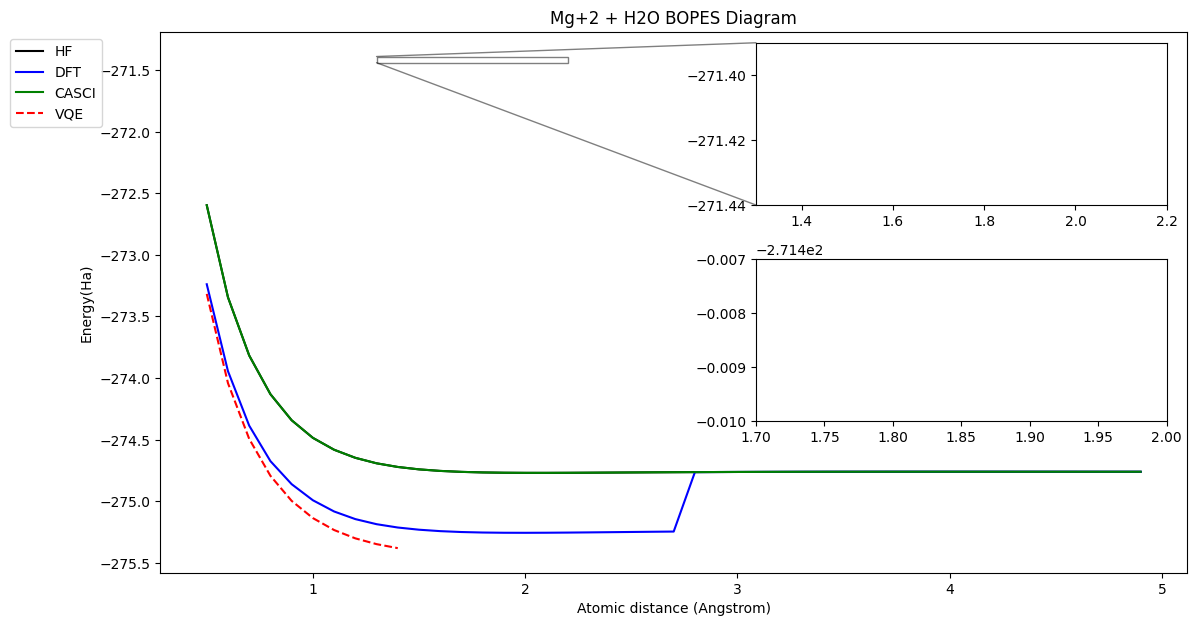

In [108]:
import matplotlib
import matplotlib.pyplot as plt

dists2=np.arange(0.5,1.5,0.1)

fig, ax=plt.subplots(1,1,figsize=(11,6))
fig.tight_layout()


#ax.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
#ax.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
ax.plot(dists,HF_engs, '-k',label="HF")
ax.plot(dists,DFT_engs, '-b',label="DFT")
ax.plot(dists,CI_engs, '-g',label="CASCI")
ax.plot(dists2,VQE_engs, '--r',label="VQE")

ax.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram')
#ax[0].set_xlim([0.7,4])
#ax[0].set_ylim([-148,-147])
ax.legend(bbox_to_anchor=(-.05,1))

axins = ax.inset_axes([0.58, 0.68, 0.4, 0.3])
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
axins.plot(dists,HF_engs, '-k',label="HF")
axins.plot(dists,DFT_engs, '-b',label="DFT")
axins.plot(dists,CI_engs, '-g',label="CASCI")
axins.plot(dists2,VQE_engs, '--r',label="VQE")

x1, x2, y1, y2 = 1.3,2.2, -271.44, -271.390
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
#axins.set_xticklabels([])
#axins.set_yticklabels([])

ax.indicate_inset_zoom(axins, edgecolor="black")

axins2 = ax.inset_axes([0.58, 0.28, 0.4, 0.3])
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
axins2.plot(dists,HF_engs, '-k',label="HF")
axins2.plot(dists,DFT_engs, '-b',label="DFT")
axins2.plot(dists,CI_engs, '-g',label="CASCI")
axins2.plot(dists2,VQE_engs, '--r',label="VQE")

xx1, xx2, yy1, yy2 = 1.7,2, -271.41, -271.407
axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)
#axins.set_xticklabels([])
#axins.set_yticklabels([])

#ax.indicate_inset_zoom(axins2, edgecolor="black")


#ax[1].plot(sim_results['RKS_distances'], -delta_classic*10**2, '--bo',label="RHF-RKS")
#ax[1].plot(sim_results['RKS_VQE_distances'], -delta_vqe*10**2, '--go',label="VQE_EMB-VQE")
#ax[1].plot(sim_results['RKS_distances'], -delta_vqecl*10**2, '--yo',label="VQE-RKS")
#ax[1].plot(sim_results['RKS_VQE_distances'], -delta_vqefci*10**2, '--co',label="VQE-FCI")
#ax[1].plot(sim_results['RKS_distances'], [0]*len(sim_results['RKS_distances']), '-r',label="Delta=0")
#ax[1].plot(sim_results['RKS_distances'], np.subtract(RHF_copy,sim_results['RKS_energies'][0])*10**3, '--bo',label="RHF-RKS")
#ax[1].plot(distances, exact_dipole,'r' ,label="Exact Energy")
#ax[1].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy Delta (%)',title="Energy Deltas between methods ")
#ax[1].legend()

plt.subplots_adjust(wspace=0.17)
plt.show()

## MG+2 + CO2

In [5]:
from functools import reduce
import numpy
import scipy.linalg
from pyscf import scf
from pyscf import gto, dft
from pyscf import mcscf, fci, mp
from functools import reduce
import numpy as np
from pyscf import gto
from pyscf import scf
from pyscf import mcscf
from pyscf import fci
from pyscf.mcscf import avas, dmet_cas

dists=np.arange(0.3,3.6,0.3) 

HF_engs=[]
DFT_engs=[]
CASSCF_engs=[]
CASCI_engs=[]
FCI_engs=[]

for d in range(len(dists)):

    mol = gto.Mole()
    mol.atom = [
        ['C',(0.0,0.0,0)],
        ['O',(-1.1621,0.0,0.0),],
        ['O',(1.1621,0.0,0.0)],
        ['Mg',(dists[d]+1.1621, 0.0, 0.0)]
        ]
    mol.charge=2
    mol.basis = '6-31g*'
    mol.verbose = 4
    mol.spin = 0
    mol.build()
#HF
    print('ROHF result')
    mf = scf.ROHF(mol)
    HF_eng=mf.kernel()
    
#DFT
    print('ROKS result')
    mdft = dft.ROKS(mol).density_fit(auxbasis='def2-universal-jfit')
    mdft.xc ='b3lyp'
    mdft.max_cycle = 50
    mdft.conv_tol = 1e-6
    
    first_run=mdft.kernel()
    a = mdft.stability()[0]
    if(mdft.converged):
        DFT_eng=first_run
    else:
        mdft.max_cycle = 80
        mdft.conv_tol = 1e-6
        mdft = scf.newton(mf)
        scnd_run=mdft.kernel(dm0 = mf.make_rdm1(a,mf.mo_occ)) # using rdm1 constructed from stability analysis
      #mf.kernel(mf.make_rdm1()) #using the rdm from the non-converged calculation
        if(mdft.converged):
            DFT_eng=scnd_run
        else:
            mdft.conv_tol = 1e-6
            mdft.max_cycle = 80
            mdft = scf.newton(mf) #Second order solver
            DFT_eng=mdft.kernel(dm0 = mf.make_rdm1())
            
    ao_labels = ['Mg 2p','Mg 3d', 'O 2p']
    norb, ne_act, orbs = avas.avas(mdft, ao_labels, canonicalize=False)

#CASCI
    print('CASSCI result')
    
    mymp = mp.UMP2(mdft).run()

    noons, natorbs = mcscf.addons.make_natural_orbitals(mymp)
    mycasci = mcscf.CASCI(mf, norb, ne_act)
    CASCI_eng=mycasci.kernel(natorbs)
#FCI
    print('FCI result')
    #cisolver = fci.FCI(mf)
    #FCI_eng=cisolver.kernel()[0]
    
    HF_engs.append(HF_eng)
    DFT_engs.append(DFT_eng)
    #CASSCF_engs.append(CASSCF_eng)
    CASCI_engs.append(CASCI_eng)
    #FCI_engs.append(FCI_eng)
    

System: uname_result(system='Darwin', node='IBM-Marco-Mac.local', release='21.6.0', version='Darwin Kernel Version 21.6.0: Mon Aug 22 20:20:05 PDT 2022; root:xnu-8020.140.49~2/RELEASE_ARM64_T8101', machine='arm64')  Threads 1
Python 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) 
[Clang 13.0.1 ]
numpy 1.24.1  scipy 1.10.0
Date: Thu Mar  2 15:04:10 2023
PySCF version 2.0.1
PySCF path  /Users/marco/pyscf
GIT ORIG_HEAD 9d5b5bd309d1cc55fbd1a0ec76e26b5b0c7f76af
GIT HEAD (branch master) 2d2e15dc37a984045ed98a86ff4008dee3d70917

[ENV] PYSCF_EXT_PATH /Users/marco/pyscf:/Users/marco/pyscf:
[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 4
[INPUT] num. electrons = 32
[INPUT] charge = 2
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 C      0.000000000000   0

In [6]:
CI_engs=[item[0] for item in CASCI_engs]
write_list(HF_engs,'Mg+CO2/simulations/pyscf_HF_results')
write_list(DFT_engs,'Mg+CO2/simulations/pyscf_DFT_results')
write_list(CI_engs,'Mg+CO2/simulations/pyscf_CASCI_results')

Done writing list into a binary file
Done writing list into a binary file
Done writing list into a binary file


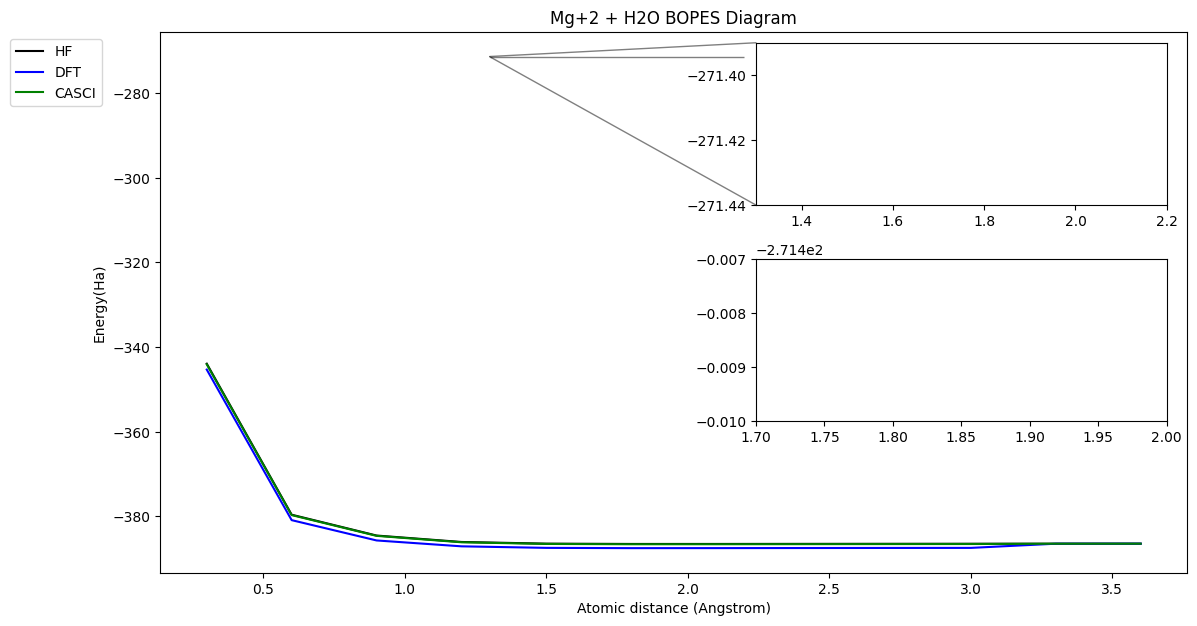

In [26]:
import matplotlib
import matplotlib.pyplot as plt

dists2=np.arange(0.5,1.5,0.1)

fig, ax=plt.subplots(1,1,figsize=(11,6))
fig.tight_layout()


#ax.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
#ax.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
ax.plot(dists,HF_engs, '-k',label="HF")
ax.plot(dists,DFT_engs, '-b',label="DFT")
ax.plot(dists,CI_engs, '-g',label="CASCI")
#ax.plot(dists2,VQE_engs, '--r',label="VQE")

ax.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram')
#ax[0].set_xlim([0.7,4])
#ax[0].set_ylim([-148,-147])
ax.legend(bbox_to_anchor=(-.05,1))

axins = ax.inset_axes([0.58, 0.68, 0.4, 0.3])
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
axins.plot(dists,HF_engs, '-k',label="HF")
axins.plot(dists,DFT_engs, '-b',label="DFT")
axins.plot(dists,CI_engs, '-g',label="CASCI")
#axins.plot(dists2,VQE_engs, '--r',label="VQE")

x1, x2, y1, y2 = 1.3,2.2, -271.44, -271.390
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
#axins.set_xticklabels([])
#axins.set_yticklabels([])

ax.indicate_inset_zoom(axins, edgecolor="black")

axins2 = ax.inset_axes([0.58, 0.28, 0.4, 0.3])
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
axins2.plot(dists,HF_engs, '-k',label="HF")
axins2.plot(dists,DFT_engs, '-b',label="DFT")
axins2.plot(dists,CI_engs, '-g',label="CASCI")
#axins2.plot(dists2,VQE_engs, '--r',label="VQE")

xx1, xx2, yy1, yy2 = 1.7,2, -271.41, -271.407
axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)
#axins.set_xticklabels([])
#axins.set_yticklabels([])

#ax.indicate_inset_zoom(axins2, edgecolor="black")


#ax[1].plot(sim_results['RKS_distances'], -delta_classic*10**2, '--bo',label="RHF-RKS")
#ax[1].plot(sim_results['RKS_VQE_distances'], -delta_vqe*10**2, '--go',label="VQE_EMB-VQE")
#ax[1].plot(sim_results['RKS_distances'], -delta_vqecl*10**2, '--yo',label="VQE-RKS")
#ax[1].plot(sim_results['RKS_VQE_distances'], -delta_vqefci*10**2, '--co',label="VQE-FCI")
#ax[1].plot(sim_results['RKS_distances'], [0]*len(sim_results['RKS_distances']), '-r',label="Delta=0")
#ax[1].plot(sim_results['RKS_distances'], np.subtract(RHF_copy,sim_results['RKS_energies'][0])*10**3, '--bo',label="RHF-RKS")
#ax[1].plot(distances, exact_dipole,'r' ,label="Exact Energy")
#ax[1].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy Delta (%)',title="Energy Deltas between methods ")
#ax[1].legend()

plt.subplots_adjust(wspace=0.17)
plt.show()

In [25]:
CI_engs

[-344.1013679053263,
 -379.71330751543894,
 -384.617967560975,
 -386.13706292042673,
 -386.52787441263104,
 -386.6011038983875,
 -386.59781933691954,
 -386.5796708498981,
 -386.5624027168279,
 -386.5493291082755,
 -386.4722213252203,
 -386.4655095093805]

## MG+2 + N2

In [8]:
from functools import reduce
import numpy
import scipy.linalg
from pyscf import scf
from pyscf import gto, dft
from pyscf import mcscf, fci, mp
from functools import reduce
import numpy as np
from pyscf import gto
from pyscf import scf
from pyscf import mcscf
from pyscf import fci
from pyscf.mcscf import avas, dmet_cas

dists=np.arange(0.3,3.6,0.3) 

HF_engs=[]
DFT_engs=[]
CASSCF_engs=[]
CASCI_engs=[]
FCI_engs=[]

for d in range(len(dists)):

    mol = gto.Mole()
    mol.atom = [
        ['N',(0.0,0.0,0)],
        ['N',(1.0977,0.0,0.0),],
        ['Mg',(dists[d]+1.0977, 0.0, 0.0)]
        ]
    mol.charge=2
    mol.basis = '6-31g*'
    mol.verbose = 4
    mol.spin = 0
    mol.build()
#HF
    print('ROHF result')
    mf = scf.ROHF(mol)
    HF_eng=mf.kernel()
    
#DFT
    print('ROKS result')
    mdft = dft.ROKS(mol).density_fit(auxbasis='def2-universal-jfit')
    mdft.xc ='b3lyp'
    mdft.max_cycle = 50
    mdft.conv_tol = 1e-6
    
    first_run=mdft.kernel()
    a = mdft.stability()[0]
    if(mdft.converged):
        DFT_eng=first_run
    else:
        mdft.max_cycle = 80
        mdft.conv_tol = 1e-6
        mdft = scf.newton(mf)
        scnd_run=mdft.kernel(dm0 = mf.make_rdm1(a,mf.mo_occ)) # using rdm1 constructed from stability analysis
      #mf.kernel(mf.make_rdm1()) #using the rdm from the non-converged calculation
        if(mdft.converged):
            DFT_eng=scnd_run
        else:
            mdft.conv_tol = 1e-6
            mdft.max_cycle = 80
            mdft = scf.newton(mf) #Second order solver
            DFT_eng=mdft.kernel(dm0 = mf.make_rdm1())
            
    ao_labels = ['Mg 2p','Mg 3d', 'N 2p']
    norb, ne_act, orbs = avas.avas(mdft, ao_labels, canonicalize=False)

#CASCI
    print('CASSCI result')
    
    mymp = mp.UMP2(mdft).run()

    noons, natorbs = mcscf.addons.make_natural_orbitals(mymp)
    mycasci = mcscf.CASCI(mf, norb, ne_act)
    CASCI_eng=mycasci.kernel(natorbs)
#FCI
    print('FCI result')
    #cisolver = fci.FCI(mf)
    #FCI_eng=cisolver.kernel()[0]
    
    HF_engs.append(HF_eng)
    DFT_engs.append(DFT_eng)
    #CASSCF_engs.append(CASSCF_eng)
    CASCI_engs.append(CASCI_eng)
    #FCI_engs.append(FCI_eng)

System: uname_result(system='Darwin', node='IBM-Marco-Mac.local', release='21.6.0', version='Darwin Kernel Version 21.6.0: Mon Aug 22 20:20:05 PDT 2022; root:xnu-8020.140.49~2/RELEASE_ARM64_T8101', machine='arm64')  Threads 1
Python 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) 
[Clang 13.0.1 ]
numpy 1.24.1  scipy 1.10.0
Date: Thu Mar  2 15:40:13 2023
PySCF version 2.0.1
PySCF path  /Users/marco/pyscf
GIT ORIG_HEAD 9d5b5bd309d1cc55fbd1a0ec76e26b5b0c7f76af
GIT HEAD (branch master) 2d2e15dc37a984045ed98a86ff4008dee3d70917

[ENV] PYSCF_EXT_PATH /Users/marco/pyscf:/Users/marco/pyscf:
[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 3
[INPUT] num. electrons = 24
[INPUT] charge = 2
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 N      0.000000000000   0

In [9]:
CI_engs=[item[0] for item in CASCI_engs]
write_list(HF_engs,'Mg+N2/simulations/pyscf_HF_results')
write_list(DFT_engs,'Mg+N2/simulations/pyscf_DFT_results')
write_list(CI_engs,'Mg+N2/simulations/pyscf_CASCI_results')

Done writing list into a binary file
Done writing list into a binary file
Done writing list into a binary file


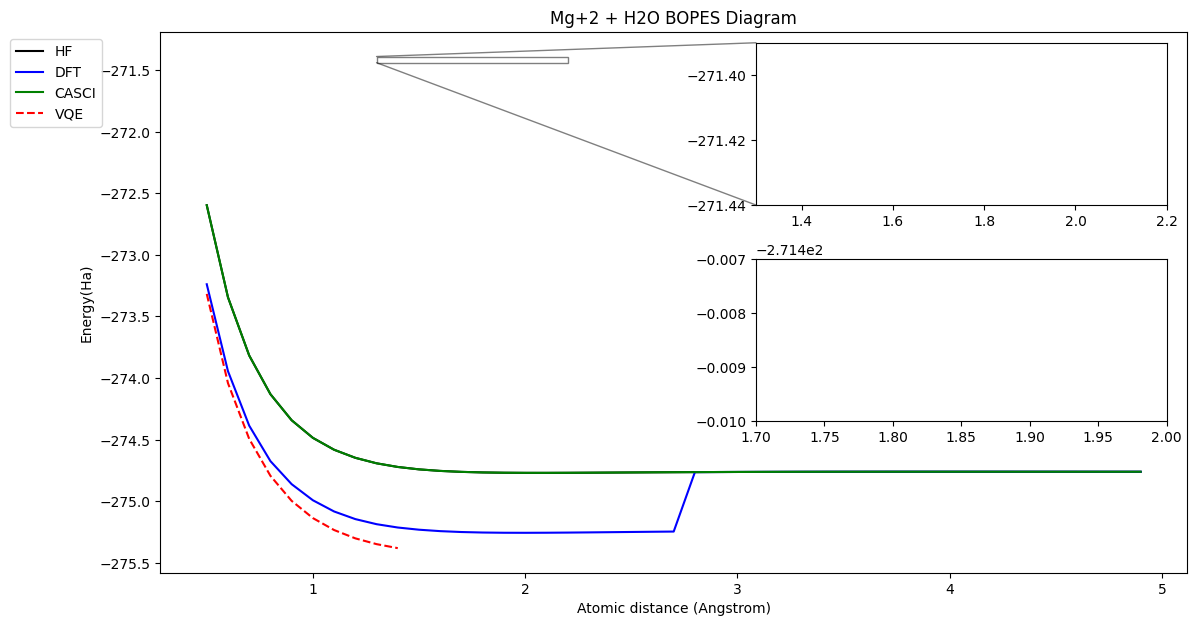

In [108]:
import matplotlib
import matplotlib.pyplot as plt

dists2=np.arange(0.5,1.5,0.1)

fig, ax=plt.subplots(1,1,figsize=(11,6))
fig.tight_layout()


#ax.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
#ax.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
ax.plot(dists,HF_engs, '-k',label="HF")
ax.plot(dists,DFT_engs, '-b',label="DFT")
ax.plot(dists,CI_engs, '-g',label="CASCI")
ax.plot(dists2,VQE_engs, '--r',label="VQE")

ax.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram')
#ax[0].set_xlim([0.7,4])
#ax[0].set_ylim([-148,-147])
ax.legend(bbox_to_anchor=(-.05,1))

axins = ax.inset_axes([0.58, 0.68, 0.4, 0.3])
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
axins.plot(dists,HF_engs, '-k',label="HF")
axins.plot(dists,DFT_engs, '-b',label="DFT")
axins.plot(dists,CI_engs, '-g',label="CASCI")
axins.plot(dists2,VQE_engs, '--r',label="VQE")

x1, x2, y1, y2 = 1.3,2.2, -271.44, -271.390
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
#axins.set_xticklabels([])
#axins.set_yticklabels([])

ax.indicate_inset_zoom(axins, edgecolor="black")

axins2 = ax.inset_axes([0.58, 0.28, 0.4, 0.3])
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
axins2.plot(dists,HF_engs, '-k',label="HF")
axins2.plot(dists,DFT_engs, '-b',label="DFT")
axins2.plot(dists,CI_engs, '-g',label="CASCI")
axins2.plot(dists2,VQE_engs, '--r',label="VQE")

xx1, xx2, yy1, yy2 = 1.7,2, -271.41, -271.407
axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)
#axins.set_xticklabels([])
#axins.set_yticklabels([])

#ax.indicate_inset_zoom(axins2, edgecolor="black")


#ax[1].plot(sim_results['RKS_distances'], -delta_classic*10**2, '--bo',label="RHF-RKS")
#ax[1].plot(sim_results['RKS_VQE_distances'], -delta_vqe*10**2, '--go',label="VQE_EMB-VQE")
#ax[1].plot(sim_results['RKS_distances'], -delta_vqecl*10**2, '--yo',label="VQE-RKS")
#ax[1].plot(sim_results['RKS_VQE_distances'], -delta_vqefci*10**2, '--co',label="VQE-FCI")
#ax[1].plot(sim_results['RKS_distances'], [0]*len(sim_results['RKS_distances']), '-r',label="Delta=0")
#ax[1].plot(sim_results['RKS_distances'], np.subtract(RHF_copy,sim_results['RKS_energies'][0])*10**3, '--bo',label="RHF-RKS")
#ax[1].plot(distances, exact_dipole,'r' ,label="Exact Energy")
#ax[1].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy Delta (%)',title="Energy Deltas between methods ")
#ax[1].legend()

plt.subplots_adjust(wspace=0.17)
plt.show()

## Zn+2 + H2O

In [ ]:
from functools import reduce
import numpy
import scipy.linalg
from pyscf import scf
from pyscf import gto, dft
from pyscf import mcscf, fci, mp
from functools import reduce
import numpy as np
from pyscf import gto
from pyscf import scf
from pyscf import mcscf
from pyscf import fci
from pyscf.mcscf import avas, dmet_cas

dists=np.arange(0.3,3.6,0.3) 

HF_engs=[]
DFT_engs=[]
CASSCF_engs=[]
CASCI_engs=[]
FCI_engs=[]

for d in range(len(dists)):

    mol = gto.Mole()
    mol.atom = [
        # ['O',(d+0.504284,0.0,0.758602)],
        # ['H',(d,0.0,0.0),],
        # ['H',(d+2*0.504284,0.0,0.0)],
        # ['Mg',(0.0, 0.0, 0.0)]
        ['O',(0.0,0.0,0)],
        ['H',(-0.504284,0.0,-0.758602),],
        ['H',(0.504284,0.0,-0.758602)],
        ['Zn',(0.0, 0.0, dists[d])]
        ]
    mol.charge=2
    mol.basis = '6-31g*'
    mol.verbose = 4
    mol.spin = 0
    mol.build()
#HF
    print('ROHF result')
    mf = scf.ROHF(mol)
    HF_eng=mf.kernel()
    
#DFT
    print('ROKS result')
    mdft = dft.ROKS(mol).density_fit(auxbasis='def2-universal-jfit')
    mdft.xc ='b3lyp'
    mdft.max_cycle = 50
    mdft.conv_tol = 1e-6
    
    first_run=mdft.kernel()
    a = mdft.stability()[0]
    if(mdft.converged):
        DFT_eng=first_run
    else:
        mdft.max_cycle = 80
        mdft.conv_tol = 1e-6
        mdft = scf.newton(mf)
        scnd_run=mdft.kernel(dm0 = mf.make_rdm1(a,mf.mo_occ)) # using rdm1 constructed from stability analysis
      #mf.kernel(mf.make_rdm1()) #using the rdm from the non-converged calculation
        if(mdft.converged):
            DFT_eng=scnd_run
        else:
            mdft.conv_tol = 1e-6
            mdft.max_cycle = 80
            mdft = scf.newton(mf) #Second order solver
            DFT_eng=mdft.kernel(dm0 = mf.make_rdm1())
            
    ao_labels = ['Zn 3d','Zn 4s', 'O 2p']
    norb, ne_act, orbs = avas.avas(mdft, ao_labels, canonicalize=False)

#CASCI
    print('CASSCI result')
    
    mymp = mp.UMP2(mdft).run()

    noons, natorbs = mcscf.addons.make_natural_orbitals(mymp)
    mycasci = mcscf.CASCI(mf, norb, ne_act)
    CASCI_eng=mycasci.kernel(natorbs)
#FCI
    print('FCI result')
    #cisolver = fci.FCI(mf)
    #FCI_eng=cisolver.kernel()[0]
    
    HF_engs.append(HF_eng)
    DFT_engs.append(DFT_eng)
    #CASSCF_engs.append(CASSCF_eng)
    CASCI_engs.append(CASCI_eng)
    #FCI_engs.append(FCI_eng)

In [11]:
CI_engs=[item[0] for item in CASCI_engs]
write_list(HF_engs,'Zn+H2O/simulations/pyscf_HF_results')
write_list(DFT_engs,'Zn+H2O/simulations/pyscf_DFT_results')
write_list(CI_engs,'Zn+H2O/simulations/pyscf_CASCI_results')

Done writing list into a binary file
Done writing list into a binary file
Done writing list into a binary file


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

dists2=np.arange(0.5,1.5,0.1)

fig, ax=plt.subplots(1,1,figsize=(11,6))
fig.tight_layout()


#ax.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
#ax.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
ax.plot(dists,HF_engs, '-k',label="HF")
ax.plot(dists,DFT_engs, '-b',label="DFT")
ax.plot(dists,CI_engs, '-g',label="CASCI")
ax.plot(dists2,VQE_engs, '--r',label="VQE")

ax.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram')
#ax[0].set_xlim([0.7,4])
#ax[0].set_ylim([-148,-147])
ax.legend(bbox_to_anchor=(-.05,1))

axins = ax.inset_axes([0.58, 0.68, 0.4, 0.3])
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
axins.plot(dists,HF_engs, '-k',label="HF")
axins.plot(dists,DFT_engs, '-b',label="DFT")
axins.plot(dists,CI_engs, '-g',label="CASCI")
axins.plot(dists2,VQE_engs, '--r',label="VQE")

x1, x2, y1, y2 = 1.3,2.2, -271.44, -271.390
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
#axins.set_xticklabels([])
#axins.set_yticklabels([])

ax.indicate_inset_zoom(axins, edgecolor="black")

axins2 = ax.inset_axes([0.58, 0.28, 0.4, 0.3])
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
axins2.plot(dists,HF_engs, '-k',label="HF")
axins2.plot(dists,DFT_engs, '-b',label="DFT")
axins2.plot(dists,CI_engs, '-g',label="CASCI")
axins2.plot(dists2,VQE_engs, '--r',label="VQE")

xx1, xx2, yy1, yy2 = 1.7,2, -271.41, -271.407
axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)
#axins.set_xticklabels([])
#axins.set_yticklabels([])

#ax.indicate_inset_zoom(axins2, edgecolor="black")


#ax[1].plot(sim_results['RKS_distances'], -delta_classic*10**2, '--bo',label="RHF-RKS")
#ax[1].plot(sim_results['RKS_VQE_distances'], -delta_vqe*10**2, '--go',label="VQE_EMB-VQE")
#ax[1].plot(sim_results['RKS_distances'], -delta_vqecl*10**2, '--yo',label="VQE-RKS")
#ax[1].plot(sim_results['RKS_VQE_distances'], -delta_vqefci*10**2, '--co',label="VQE-FCI")
#ax[1].plot(sim_results['RKS_distances'], [0]*len(sim_results['RKS_distances']), '-r',label="Delta=0")
#ax[1].plot(sim_results['RKS_distances'], np.subtract(RHF_copy,sim_results['RKS_energies'][0])*10**3, '--bo',label="RHF-RKS")
#ax[1].plot(distances, exact_dipole,'r' ,label="Exact Energy")
#ax[1].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy Delta (%)',title="Energy Deltas between methods ")
#ax[1].legend()

plt.subplots_adjust(wspace=0.17)
plt.show()

## Zn+2 + CO2

In [ ]:
from functools import reduce
import numpy
import scipy.linalg
from pyscf import scf
from pyscf import gto, dft
from pyscf import mcscf, fci, mp
from functools import reduce
import numpy as np
from pyscf import gto
from pyscf import scf
from pyscf import mcscf
from pyscf import fci
from pyscf.mcscf import avas, dmet_cas

dists=np.arange(0.3,3.6,0.3) 

HF_engs=[]
DFT_engs=[]
CASSCF_engs=[]
CASCI_engs=[]
FCI_engs=[]

for d in range(len(dists)):

    mol = gto.Mole()
    mol.atom = [
        ['C',(0.0,0.0,0)],
        ['O',(-1.1621,0.0,0.0),],
        ['O',(1.1621,0.0,0.0)],
        ['Zn',(dists[d]+1.1621, 0.0, 0.0)]
        ]
    mol.charge=2
    mol.basis = '6-31g*'
    mol.verbose = 4
    mol.spin = 0
    mol.build()
#HF
    print('ROHF result')
    mf = scf.ROHF(mol)
    HF_eng=mf.kernel()
    
#DFT
    print('ROKS result')
    mdft = dft.ROKS(mol).density_fit(auxbasis='def2-universal-jfit')
    mdft.xc ='b3lyp'
    mdft.max_cycle = 50
    mdft.conv_tol = 1e-6
    
    first_run=mdft.kernel()
    a = mdft.stability()[0]
    if(mdft.converged):
        DFT_eng=first_run
    else:
        mdft.max_cycle = 80
        mdft.conv_tol = 1e-6
        mdft = scf.newton(mf)
        scnd_run=mdft.kernel(dm0 = mf.make_rdm1(a,mf.mo_occ)) # using rdm1 constructed from stability analysis
      #mf.kernel(mf.make_rdm1()) #using the rdm from the non-converged calculation
        if(mdft.converged):
            DFT_eng=scnd_run
        else:
            mdft.conv_tol = 1e-6
            mdft.max_cycle = 80
            mdft = scf.newton(mf) #Second order solver
            DFT_eng=mdft.kernel(dm0 = mf.make_rdm1())
            
    ao_labels = ['Zn 3d','Zn 4s', 'O 2p']
    norb, ne_act, orbs = avas.avas(mdft, ao_labels, canonicalize=False)

#CASCI
    print('CASSCI result')
    
    mymp = mp.UMP2(mdft).run()

    noons, natorbs = mcscf.addons.make_natural_orbitals(mymp)
    mycasci = mcscf.CASCI(mf, norb, ne_act)
    CASCI_eng=mycasci.kernel(natorbs)
#FCI
    print('FCI result')
    #cisolver = fci.FCI(mf)
    #FCI_eng=cisolver.kernel()[0]
    
    HF_engs.append(HF_eng)
    DFT_engs.append(DFT_eng)
    #CASSCF_engs.append(CASSCF_eng)
    CASCI_engs.append(CASCI_eng)
    #FCI_engs.append(FCI_eng)

In [13]:
CI_engs=[item[0] for item in CASCI_engs]
write_list(HF_engs,'Zn+CO2/simulations/pyscf_HF_results')
write_list(DFT_engs,'Zn+CO2/simulations/pyscf_DFT_results')
write_list(CI_engs,'Zn+CO2/simulations/pyscf_CASCI_results')

Done writing list into a binary file
Done writing list into a binary file
Done writing list into a binary file


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

dists2=np.arange(0.5,1.5,0.1)

fig, ax=plt.subplots(1,1,figsize=(11,6))
fig.tight_layout()


#ax.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
#ax.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
ax.plot(dists,HF_engs, '-k',label="HF")
ax.plot(dists,DFT_engs, '-b',label="DFT")
ax.plot(dists,CI_engs, '-g',label="CASCI")
ax.plot(dists2,VQE_engs, '--r',label="VQE")

ax.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram')
#ax[0].set_xlim([0.7,4])
#ax[0].set_ylim([-148,-147])
ax.legend(bbox_to_anchor=(-.05,1))

axins = ax.inset_axes([0.58, 0.68, 0.4, 0.3])
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
axins.plot(dists,HF_engs, '-k',label="HF")
axins.plot(dists,DFT_engs, '-b',label="DFT")
axins.plot(dists,CI_engs, '-g',label="CASCI")
axins.plot(dists2,VQE_engs, '--r',label="VQE")

x1, x2, y1, y2 = 1.3,2.2, -271.44, -271.390
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
#axins.set_xticklabels([])
#axins.set_yticklabels([])

ax.indicate_inset_zoom(axins, edgecolor="black")

axins2 = ax.inset_axes([0.58, 0.28, 0.4, 0.3])
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
axins2.plot(dists,HF_engs, '-k',label="HF")
axins2.plot(dists,DFT_engs, '-b',label="DFT")
axins2.plot(dists,CI_engs, '-g',label="CASCI")
axins2.plot(dists2,VQE_engs, '--r',label="VQE")

xx1, xx2, yy1, yy2 = 1.7,2, -271.41, -271.407
axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)
#axins.set_xticklabels([])
#axins.set_yticklabels([])

#ax.indicate_inset_zoom(axins2, edgecolor="black")


#ax[1].plot(sim_results['RKS_distances'], -delta_classic*10**2, '--bo',label="RHF-RKS")
#ax[1].plot(sim_results['RKS_VQE_distances'], -delta_vqe*10**2, '--go',label="VQE_EMB-VQE")
#ax[1].plot(sim_results['RKS_distances'], -delta_vqecl*10**2, '--yo',label="VQE-RKS")
#ax[1].plot(sim_results['RKS_VQE_distances'], -delta_vqefci*10**2, '--co',label="VQE-FCI")
#ax[1].plot(sim_results['RKS_distances'], [0]*len(sim_results['RKS_distances']), '-r',label="Delta=0")
#ax[1].plot(sim_results['RKS_distances'], np.subtract(RHF_copy,sim_results['RKS_energies'][0])*10**3, '--bo',label="RHF-RKS")
#ax[1].plot(distances, exact_dipole,'r' ,label="Exact Energy")
#ax[1].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy Delta (%)',title="Energy Deltas between methods ")
#ax[1].legend()

plt.subplots_adjust(wspace=0.17)
plt.show()

## Zn+2 + N2

In [ ]:
from functools import reduce
import numpy
import scipy.linalg
from pyscf import scf
from pyscf import gto, dft
from pyscf import mcscf, fci, mp
from functools import reduce
import numpy as np
from pyscf import gto
from pyscf import scf
from pyscf import mcscf
from pyscf import fci
from pyscf.mcscf import avas, dmet_cas

dists=np.arange(0.3,3.6,0.3) 

HF_engs=[]
DFT_engs=[]
CASSCF_engs=[]
CASCI_engs=[]
FCI_engs=[]

for d in range(len(dists)):

    mol = gto.Mole()
    mol.atom = [
        ['N',(0.0,0.0,0)],
        ['N',(1.0977,0.0,0.0),],
        ['Zn',(dists[d]+1.0977, 0.0, 0.0)]
        ]
    mol.charge=2
    mol.basis = '6-31g*'
    mol.verbose = 4
    mol.spin = 0
    mol.build()
#HF
    print('ROHF result')
    mf = scf.ROHF(mol)
    HF_eng=mf.kernel()
    
#DFT
    print('ROKS result')
    mdft = dft.ROKS(mol).density_fit(auxbasis='def2-universal-jfit')
    mdft.xc ='b3lyp'
    mdft.max_cycle = 50
    mdft.conv_tol = 1e-6
    
    first_run=mdft.kernel()
    a = mdft.stability()[0]
    if(mdft.converged):
        DFT_eng=first_run
    else:
        mdft.max_cycle = 80
        mdft.conv_tol = 1e-6
        mdft = scf.newton(mf)
        scnd_run=mdft.kernel(dm0 = mf.make_rdm1(a,mf.mo_occ)) # using rdm1 constructed from stability analysis
      #mf.kernel(mf.make_rdm1()) #using the rdm from the non-converged calculation
        if(mdft.converged):
            DFT_eng=scnd_run
        else:
            mdft.conv_tol = 1e-6
            mdft.max_cycle = 80
            mdft = scf.newton(mf) #Second order solver
            DFT_eng=mdft.kernel(dm0 = mf.make_rdm1())
            
    ao_labels = ['Zn 3d','Zn 4s', 'N 2p']
    norb, ne_act, orbs = avas.avas(mdft, ao_labels, canonicalize=False)

#CASCI
    print('CASSCI result')
    
    mymp = mp.UMP2(mdft).run()

    noons, natorbs = mcscf.addons.make_natural_orbitals(mymp)
    mycasci = mcscf.CASCI(mf, norb, ne_act)
    CASCI_eng=mycasci.kernel(natorbs)
#FCI
    print('FCI result')
    #cisolver = fci.FCI(mf)
    #FCI_eng=cisolver.kernel()[0]
    
    HF_engs.append(HF_eng)
    DFT_engs.append(DFT_eng)
    #CASSCF_engs.append(CASSCF_eng)
    CASCI_engs.append(CASCI_eng)
    #FCI_engs.append(FCI_eng)

In [16]:
CI_engs=[item[0] for item in CASCI_engs]
write_list(HF_engs,'Zn+N2/simulations/pyscf_HF_results')
write_list(DFT_engs,'Zn+N2/simulations/pyscf_DFT_results')
write_list(CI_engs,'Zn+N2/simulations/pyscf_CASCI_results')

Done writing list into a binary file
Done writing list into a binary file
Done writing list into a binary file


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

dists2=np.arange(0.5,1.5,0.1)

fig, ax=plt.subplots(1,1,figsize=(11,6))
fig.tight_layout()


#ax.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
#ax.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
ax.plot(dists,HF_engs, '-k',label="HF")
ax.plot(dists,DFT_engs, '-b',label="DFT")
ax.plot(dists,CI_engs, '-g',label="CASCI")
ax.plot(dists2,VQE_engs, '--r',label="VQE")

ax.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram')
#ax[0].set_xlim([0.7,4])
#ax[0].set_ylim([-148,-147])
ax.legend(bbox_to_anchor=(-.05,1))

axins = ax.inset_axes([0.58, 0.68, 0.4, 0.3])
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
axins.plot(dists,HF_engs, '-k',label="HF")
axins.plot(dists,DFT_engs, '-b',label="DFT")
axins.plot(dists,CI_engs, '-g',label="CASCI")
axins.plot(dists2,VQE_engs, '--r',label="VQE")

x1, x2, y1, y2 = 1.3,2.2, -271.44, -271.390
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
#axins.set_xticklabels([])
#axins.set_yticklabels([])

ax.indicate_inset_zoom(axins, edgecolor="black")

axins2 = ax.inset_axes([0.58, 0.28, 0.4, 0.3])
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
axins2.plot(dists,HF_engs, '-k',label="HF")
axins2.plot(dists,DFT_engs, '-b',label="DFT")
axins2.plot(dists,CI_engs, '-g',label="CASCI")
axins2.plot(dists2,VQE_engs, '--r',label="VQE")

xx1, xx2, yy1, yy2 = 1.7,2, -271.41, -271.407
axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)
#axins.set_xticklabels([])
#axins.set_yticklabels([])

#ax.indicate_inset_zoom(axins2, edgecolor="black")


#ax[1].plot(sim_results['RKS_distances'], -delta_classic*10**2, '--bo',label="RHF-RKS")
#ax[1].plot(sim_results['RKS_VQE_distances'], -delta_vqe*10**2, '--go',label="VQE_EMB-VQE")
#ax[1].plot(sim_results['RKS_distances'], -delta_vqecl*10**2, '--yo',label="VQE-RKS")
#ax[1].plot(sim_results['RKS_VQE_distances'], -delta_vqefci*10**2, '--co',label="VQE-FCI")
#ax[1].plot(sim_results['RKS_distances'], [0]*len(sim_results['RKS_distances']), '-r',label="Delta=0")
#ax[1].plot(sim_results['RKS_distances'], np.subtract(RHF_copy,sim_results['RKS_energies'][0])*10**3, '--bo',label="RHF-RKS")
#ax[1].plot(distances, exact_dipole,'r' ,label="Exact Energy")
#ax[1].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy Delta (%)',title="Energy Deltas between methods ")
#ax[1].legend()

plt.subplots_adjust(wspace=0.17)
plt.show()

## Cu+2 + H2O

In [17]:
from functools import reduce
import numpy
import scipy.linalg
from pyscf import scf
from pyscf import gto, dft
from pyscf import mcscf, fci, mp
from functools import reduce
import numpy as np
from pyscf import gto
from pyscf import scf
from pyscf import mcscf
from pyscf import fci
from pyscf.mcscf import avas, dmet_cas

dists=np.arange(0.3,3.6,0.3) 

HF_engs=[]
DFT_engs=[]
CASSCF_engs=[]
CASCI_engs=[]
FCI_engs=[]

for d in range(len(dists)):

    mol = gto.Mole()
    mol.atom = [
        # ['O',(d+0.504284,0.0,0.758602)],
        # ['H',(d,0.0,0.0),],
        # ['H',(d+2*0.504284,0.0,0.0)],
        # ['Mg',(0.0, 0.0, 0.0)]
        ['O',(0.0,0.0,0)],
        ['H',(-0.504284,0.0,-0.758602),],
        ['H',(0.504284,0.0,-0.758602)],
        ['Cu',(0.0, 0.0, dists[d])]
        ]
    mol.charge=2
    mol.basis = '6-31g*'
    mol.verbose = 4
    mol.spin = 1
    mol.build()
#HF
    print('ROHF result')
    mf = scf.ROHF(mol)
    HF_eng=mf.kernel()
    
#DFT
    print('ROKS result')
    mdft = dft.ROKS(mol).density_fit(auxbasis='def2-universal-jfit')
    mdft.xc ='b3lyp'
    mdft.max_cycle = 50
    mdft.conv_tol = 1e-6
    
    first_run=mdft.kernel()
    a = mdft.stability()[0]
    if(mdft.converged):
        DFT_eng=first_run
    else:
        mdft.max_cycle = 80
        mdft.conv_tol = 1e-6
        mdft = scf.newton(mf)
        scnd_run=mdft.kernel(dm0 = mf.make_rdm1(a,mf.mo_occ)) # using rdm1 constructed from stability analysis
      #mf.kernel(mf.make_rdm1()) #using the rdm from the non-converged calculation
        if(mdft.converged):
            DFT_eng=scnd_run
        else:
            mdft.conv_tol = 1e-6
            mdft.max_cycle = 80
            mdft = scf.newton(mf) #Second order solver
            DFT_eng=mdft.kernel(dm0 = mf.make_rdm1())
            
    ao_labels = ['Cu 3d','Cu 4s', 'O 2p']
    norb, ne_act, orbs = avas.avas(mdft, ao_labels, canonicalize=False)

#CASCI
    print('CASSCI result')
    
    mymp = mp.UMP2(mdft).run()

    noons, natorbs = mcscf.addons.make_natural_orbitals(mymp)
    mycasci = mcscf.CASCI(mf, norb, ne_act)
    CASCI_eng=mycasci.kernel(natorbs)
#FCI
    print('FCI result')
    #cisolver = fci.FCI(mf)
    #FCI_eng=cisolver.kernel()[0]
    
    HF_engs.append(HF_eng)
    DFT_engs.append(DFT_eng)
    #CASSCF_engs.append(CASSCF_eng)
    CASCI_engs.append(CASCI_eng)
    #FCI_engs.append(FCI_eng)

System: uname_result(system='Darwin', node='IBM-Marco-Mac.local', release='21.6.0', version='Darwin Kernel Version 21.6.0: Mon Aug 22 20:20:05 PDT 2022; root:xnu-8020.140.49~2/RELEASE_ARM64_T8101', machine='arm64')  Threads 1
Python 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) 
[Clang 13.0.1 ]
numpy 1.24.1  scipy 1.10.0
Date: Thu Mar  2 18:24:27 2023
PySCF version 2.0.1
PySCF path  /Users/marco/pyscf
GIT ORIG_HEAD 9d5b5bd309d1cc55fbd1a0ec76e26b5b0c7f76af
GIT HEAD (branch master) 2d2e15dc37a984045ed98a86ff4008dee3d70917

[ENV] PYSCF_EXT_PATH /Users/marco/pyscf:/Users/marco/pyscf:
[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 4
[INPUT] num. electrons = 37
[INPUT] charge = 2
[INPUT] spin (= nelec alpha-beta = 2S) = 1
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 O      0.000000000000   0

In [18]:
CI_engs=[item[0] for item in CASCI_engs]
write_list(HF_engs,'Cu+H2O/simulations/pyscf_HF_results')
write_list(DFT_engs,'Cu+H2O/simulations/pyscf_DFT_results')
write_list(CI_engs,'Cu+H2O/simulations/pyscf_CASCI_results')

Done writing list into a binary file
Done writing list into a binary file
Done writing list into a binary file


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

dists2=np.arange(0.5,1.5,0.1)

fig, ax=plt.subplots(1,1,figsize=(11,6))
fig.tight_layout()


#ax.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
#ax.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
ax.plot(dists,HF_engs, '-k',label="HF")
ax.plot(dists,DFT_engs, '-b',label="DFT")
ax.plot(dists,CI_engs, '-g',label="CASCI")
ax.plot(dists2,VQE_engs, '--r',label="VQE")

ax.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram')
#ax[0].set_xlim([0.7,4])
#ax[0].set_ylim([-148,-147])
ax.legend(bbox_to_anchor=(-.05,1))

axins = ax.inset_axes([0.58, 0.68, 0.4, 0.3])
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
axins.plot(dists,HF_engs, '-k',label="HF")
axins.plot(dists,DFT_engs, '-b',label="DFT")
axins.plot(dists,CI_engs, '-g',label="CASCI")
axins.plot(dists2,VQE_engs, '--r',label="VQE")

x1, x2, y1, y2 = 1.3,2.2, -271.44, -271.390
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
#axins.set_xticklabels([])
#axins.set_yticklabels([])

ax.indicate_inset_zoom(axins, edgecolor="black")

axins2 = ax.inset_axes([0.58, 0.28, 0.4, 0.3])
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
axins2.plot(dists,HF_engs, '-k',label="HF")
axins2.plot(dists,DFT_engs, '-b',label="DFT")
axins2.plot(dists,CI_engs, '-g',label="CASCI")
axins2.plot(dists2,VQE_engs, '--r',label="VQE")

xx1, xx2, yy1, yy2 = 1.7,2, -271.41, -271.407
axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)
#axins.set_xticklabels([])
#axins.set_yticklabels([])

#ax.indicate_inset_zoom(axins2, edgecolor="black")


#ax[1].plot(sim_results['RKS_distances'], -delta_classic*10**2, '--bo',label="RHF-RKS")
#ax[1].plot(sim_results['RKS_VQE_distances'], -delta_vqe*10**2, '--go',label="VQE_EMB-VQE")
#ax[1].plot(sim_results['RKS_distances'], -delta_vqecl*10**2, '--yo',label="VQE-RKS")
#ax[1].plot(sim_results['RKS_VQE_distances'], -delta_vqefci*10**2, '--co',label="VQE-FCI")
#ax[1].plot(sim_results['RKS_distances'], [0]*len(sim_results['RKS_distances']), '-r',label="Delta=0")
#ax[1].plot(sim_results['RKS_distances'], np.subtract(RHF_copy,sim_results['RKS_energies'][0])*10**3, '--bo',label="RHF-RKS")
#ax[1].plot(distances, exact_dipole,'r' ,label="Exact Energy")
#ax[1].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy Delta (%)',title="Energy Deltas between methods ")
#ax[1].legend()

plt.subplots_adjust(wspace=0.17)
plt.show()

## Cu+2 + CO2

In [19]:
from functools import reduce
import numpy
import scipy.linalg
from pyscf import scf
from pyscf import gto, dft
from pyscf import mcscf, fci, mp
from functools import reduce
import numpy as np
from pyscf import gto
from pyscf import scf
from pyscf import mcscf
from pyscf import fci
from pyscf.mcscf import avas, dmet_cas

dists=np.arange(0.3,3.6,0.3) 

HF_engs=[]
DFT_engs=[]
CASSCF_engs=[]
CASCI_engs=[]
FCI_engs=[]

for d in range(len(dists)):

    mol = gto.Mole()
    mol.atom = [
        ['C',(0.0,0.0,0)],
        ['O',(-1.1621,0.0,0.0),],
        ['O',(1.1621,0.0,0.0)],
        ['Cu',(dists[d]+1.1621, 0.0, 0.0)]
        ]
    mol.charge=2
    mol.basis = '6-31g*'
    mol.verbose = 4
    mol.spin = 1
    mol.build()
#HF
    print('ROHF result')
    mf = scf.ROHF(mol)
    HF_eng=mf.kernel()
    
#DFT
    print('ROKS result')
    mdft = dft.ROKS(mol).density_fit(auxbasis='def2-universal-jfit')
    mdft.xc ='b3lyp'
    mdft.max_cycle = 50
    mdft.conv_tol = 1e-6
    
    first_run=mdft.kernel()
    a = mdft.stability()[0]
    if(mdft.converged):
        DFT_eng=first_run
    else:
        mdft.max_cycle = 80
        mdft.conv_tol = 1e-6
        mdft = scf.newton(mf)
        scnd_run=mdft.kernel(dm0 = mf.make_rdm1(a,mf.mo_occ)) # using rdm1 constructed from stability analysis
      #mf.kernel(mf.make_rdm1()) #using the rdm from the non-converged calculation
        if(mdft.converged):
            DFT_eng=scnd_run
        else:
            mdft.conv_tol = 1e-6
            mdft.max_cycle = 80
            mdft = scf.newton(mf) #Second order solver
            DFT_eng=mdft.kernel(dm0 = mf.make_rdm1())
            
    ao_labels = ['Cu 3d','Cu 4s', 'O 2p']
    norb, ne_act, orbs = avas.avas(mdft, ao_labels, canonicalize=False)

#CASCI
    print('CASSCI result')
    
    mymp = mp.UMP2(mdft).run()

    noons, natorbs = mcscf.addons.make_natural_orbitals(mymp)
    mycasci = mcscf.CASCI(mf, norb, ne_act)
    CASCI_eng=mycasci.kernel(natorbs)
#FCI
    print('FCI result')
    #cisolver = fci.FCI(mf)
    #FCI_eng=cisolver.kernel()[0]
    
    HF_engs.append(HF_eng)
    DFT_engs.append(DFT_eng)
    #CASSCF_engs.append(CASSCF_eng)
    CASCI_engs.append(CASCI_eng)
    #FCI_engs.append(FCI_eng)

System: uname_result(system='Darwin', node='IBM-Marco-Mac.local', release='21.6.0', version='Darwin Kernel Version 21.6.0: Mon Aug 22 20:20:05 PDT 2022; root:xnu-8020.140.49~2/RELEASE_ARM64_T8101', machine='arm64')  Threads 1
Python 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) 
[Clang 13.0.1 ]
numpy 1.24.1  scipy 1.10.0
Date: Thu Mar  2 18:30:01 2023
PySCF version 2.0.1
PySCF path  /Users/marco/pyscf
GIT ORIG_HEAD 9d5b5bd309d1cc55fbd1a0ec76e26b5b0c7f76af
GIT HEAD (branch master) 2d2e15dc37a984045ed98a86ff4008dee3d70917

[ENV] PYSCF_EXT_PATH /Users/marco/pyscf:/Users/marco/pyscf:
[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 4
[INPUT] num. electrons = 49
[INPUT] charge = 2
[INPUT] spin (= nelec alpha-beta = 2S) = 1
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 C      0.000000000000   0

In [20]:
CI_engs=[item[0] for item in CASCI_engs]
write_list(HF_engs,'Cu+CO2/simulations/pyscf_HF_results')
write_list(DFT_engs,'Cu+CO2/simulations/pyscf_DFT_results')
write_list(CI_engs,'Cu+CO2/simulations/pyscf_CASCI_results')

Done writing list into a binary file
Done writing list into a binary file
Done writing list into a binary file


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

dists2=np.arange(0.5,1.5,0.1)

fig, ax=plt.subplots(1,1,figsize=(11,6))
fig.tight_layout()


#ax.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
#ax.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
ax.plot(dists,HF_engs, '-k',label="HF")
ax.plot(dists,DFT_engs, '-b',label="DFT")
ax.plot(dists,CI_engs, '-g',label="CASCI")
ax.plot(dists2,VQE_engs, '--r',label="VQE")

ax.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram')
#ax[0].set_xlim([0.7,4])
#ax[0].set_ylim([-148,-147])
ax.legend(bbox_to_anchor=(-.05,1))

axins = ax.inset_axes([0.58, 0.68, 0.4, 0.3])
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
axins.plot(dists,HF_engs, '-k',label="HF")
axins.plot(dists,DFT_engs, '-b',label="DFT")
axins.plot(dists,CI_engs, '-g',label="CASCI")
axins.plot(dists2,VQE_engs, '--r',label="VQE")

x1, x2, y1, y2 = 1.3,2.2, -271.44, -271.390
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
#axins.set_xticklabels([])
#axins.set_yticklabels([])

ax.indicate_inset_zoom(axins, edgecolor="black")

axins2 = ax.inset_axes([0.58, 0.28, 0.4, 0.3])
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
axins2.plot(dists,HF_engs, '-k',label="HF")
axins2.plot(dists,DFT_engs, '-b',label="DFT")
axins2.plot(dists,CI_engs, '-g',label="CASCI")
axins2.plot(dists2,VQE_engs, '--r',label="VQE")

xx1, xx2, yy1, yy2 = 1.7,2, -271.41, -271.407
axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)
#axins.set_xticklabels([])
#axins.set_yticklabels([])

#ax.indicate_inset_zoom(axins2, edgecolor="black")


#ax[1].plot(sim_results['RKS_distances'], -delta_classic*10**2, '--bo',label="RHF-RKS")
#ax[1].plot(sim_results['RKS_VQE_distances'], -delta_vqe*10**2, '--go',label="VQE_EMB-VQE")
#ax[1].plot(sim_results['RKS_distances'], -delta_vqecl*10**2, '--yo',label="VQE-RKS")
#ax[1].plot(sim_results['RKS_VQE_distances'], -delta_vqefci*10**2, '--co',label="VQE-FCI")
#ax[1].plot(sim_results['RKS_distances'], [0]*len(sim_results['RKS_distances']), '-r',label="Delta=0")
#ax[1].plot(sim_results['RKS_distances'], np.subtract(RHF_copy,sim_results['RKS_energies'][0])*10**3, '--bo',label="RHF-RKS")
#ax[1].plot(distances, exact_dipole,'r' ,label="Exact Energy")
#ax[1].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy Delta (%)',title="Energy Deltas between methods ")
#ax[1].legend()

plt.subplots_adjust(wspace=0.17)
plt.show()

## Cu+2 + N2

In [21]:
from functools import reduce
import numpy
import scipy.linalg
from pyscf import scf
from pyscf import gto, dft
from pyscf import mcscf, fci, mp
from functools import reduce
import numpy as np
from pyscf import gto
from pyscf import scf
from pyscf import mcscf
from pyscf import fci
from pyscf.mcscf import avas, dmet_cas

dists=np.arange(0.3,3.6,0.3) 

HF_engs=[]
DFT_engs=[]
CASSCF_engs=[]
CASCI_engs=[]
FCI_engs=[]

for d in range(len(dists)):

    mol = gto.Mole()
    mol.atom = [
        ['N',(0.0,0.0,0)],
        ['N',(1.0977,0.0,0.0),],
        ['Cu',(dists[d]+1.0977, 0.0, 0.0)]
        ]
    mol.charge=2
    mol.basis = '6-31g*'
    mol.verbose = 4
    mol.spin = 1
    mol.build()
#HF
    print('ROHF result')
    mf = scf.ROHF(mol)
    HF_eng=mf.kernel()
    
#DFT
    print('ROKS result')
    mdft = dft.ROKS(mol).density_fit(auxbasis='def2-universal-jfit')
    mdft.xc ='b3lyp'
    mdft.max_cycle = 50
    mdft.conv_tol = 1e-6
    
    first_run=mdft.kernel()
    a = mdft.stability()[0]
    if(mdft.converged):
        DFT_eng=first_run
    else:
        mdft.max_cycle = 80
        mdft.conv_tol = 1e-6
        mdft = scf.newton(mf)
        scnd_run=mdft.kernel(dm0 = mf.make_rdm1(a,mf.mo_occ)) # using rdm1 constructed from stability analysis
      #mf.kernel(mf.make_rdm1()) #using the rdm from the non-converged calculation
        if(mdft.converged):
            DFT_eng=scnd_run
        else:
            mdft.conv_tol = 1e-6
            mdft.max_cycle = 80
            mdft = scf.newton(mf) #Second order solver
            DFT_eng=mdft.kernel(dm0 = mf.make_rdm1())
            
    ao_labels = ['Cu 3d','Cu 4s', 'N 2p']
    norb, ne_act, orbs = avas.avas(mdft, ao_labels, canonicalize=False)

#CASCI
    print('CASSCI result')
    
    mymp = mp.UMP2(mdft).run()

    noons, natorbs = mcscf.addons.make_natural_orbitals(mymp)
    mycasci = mcscf.CASCI(mf, norb, ne_act)
    CASCI_eng=mycasci.kernel(natorbs)
#FCI
    print('FCI result')
    #cisolver = fci.FCI(mf)
    #FCI_eng=cisolver.kernel()[0]
    
    HF_engs.append(HF_eng)
    DFT_engs.append(DFT_eng)
    #CASSCF_engs.append(CASSCF_eng)
    CASCI_engs.append(CASCI_eng)
    #FCI_engs.append(FCI_eng)

System: uname_result(system='Darwin', node='IBM-Marco-Mac.local', release='21.6.0', version='Darwin Kernel Version 21.6.0: Mon Aug 22 20:20:05 PDT 2022; root:xnu-8020.140.49~2/RELEASE_ARM64_T8101', machine='arm64')  Threads 1
Python 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) 
[Clang 13.0.1 ]
numpy 1.24.1  scipy 1.10.0
Date: Thu Mar  2 18:54:22 2023
PySCF version 2.0.1
PySCF path  /Users/marco/pyscf
GIT ORIG_HEAD 9d5b5bd309d1cc55fbd1a0ec76e26b5b0c7f76af
GIT HEAD (branch master) 2d2e15dc37a984045ed98a86ff4008dee3d70917

[ENV] PYSCF_EXT_PATH /Users/marco/pyscf:/Users/marco/pyscf:
[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 3
[INPUT] num. electrons = 41
[INPUT] charge = 2
[INPUT] spin (= nelec alpha-beta = 2S) = 1
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 N      0.000000000000   0

In [22]:
CI_engs=[item[0] for item in CASCI_engs]
write_list(HF_engs,'Cu+N2/simulations/pyscf_HF_results')
write_list(DFT_engs,'Cu+N2/simulations/pyscf_DFT_results')
write_list(CI_engs,'Cu+N2/simulations/pyscf_CASCI_results')

Done writing list into a binary file
Done writing list into a binary file
Done writing list into a binary file


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

dists2=np.arange(0.5,1.5,0.1)

fig, ax=plt.subplots(1,1,figsize=(11,6))
fig.tight_layout()


#ax.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
#ax.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
ax.plot(dists,HF_engs, '-k',label="HF")
ax.plot(dists,DFT_engs, '-b',label="DFT")
ax.plot(dists,CI_engs, '-g',label="CASCI")
ax.plot(dists2,VQE_engs, '--r',label="VQE")

ax.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram')
#ax[0].set_xlim([0.7,4])
#ax[0].set_ylim([-148,-147])
ax.legend(bbox_to_anchor=(-.05,1))

axins = ax.inset_axes([0.58, 0.68, 0.4, 0.3])
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
axins.plot(dists,HF_engs, '-k',label="HF")
axins.plot(dists,DFT_engs, '-b',label="DFT")
axins.plot(dists,CI_engs, '-g',label="CASCI")
axins.plot(dists2,VQE_engs, '--r',label="VQE")

x1, x2, y1, y2 = 1.3,2.2, -271.44, -271.390
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
#axins.set_xticklabels([])
#axins.set_yticklabels([])

ax.indicate_inset_zoom(axins, edgecolor="black")

axins2 = ax.inset_axes([0.58, 0.28, 0.4, 0.3])
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
axins2.plot(dists,HF_engs, '-k',label="HF")
axins2.plot(dists,DFT_engs, '-b',label="DFT")
axins2.plot(dists,CI_engs, '-g',label="CASCI")
axins2.plot(dists2,VQE_engs, '--r',label="VQE")

xx1, xx2, yy1, yy2 = 1.7,2, -271.41, -271.407
axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)
#axins.set_xticklabels([])
#axins.set_yticklabels([])

#ax.indicate_inset_zoom(axins2, edgecolor="black")


#ax[1].plot(sim_results['RKS_distances'], -delta_classic*10**2, '--bo',label="RHF-RKS")
#ax[1].plot(sim_results['RKS_VQE_distances'], -delta_vqe*10**2, '--go',label="VQE_EMB-VQE")
#ax[1].plot(sim_results['RKS_distances'], -delta_vqecl*10**2, '--yo',label="VQE-RKS")
#ax[1].plot(sim_results['RKS_VQE_distances'], -delta_vqefci*10**2, '--co',label="VQE-FCI")
#ax[1].plot(sim_results['RKS_distances'], [0]*len(sim_results['RKS_distances']), '-r',label="Delta=0")
#ax[1].plot(sim_results['RKS_distances'], np.subtract(RHF_copy,sim_results['RKS_energies'][0])*10**3, '--bo',label="RHF-RKS")
#ax[1].plot(distances, exact_dipole,'r' ,label="Exact Energy")
#ax[1].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy Delta (%)',title="Energy Deltas between methods ")
#ax[1].legend()

plt.subplots_adjust(wspace=0.17)
plt.show()

# DRAFT

In [21]:
#!/usr/bin/env python
#
# Author: Qiming Sun <osirpt.sun@gmail.com>
#

import sys
from pyscf import gto, scf
from pyscf import lo
from pyscf.tools import molden

'''
Write orbitals in molden format
'''

mol = gto.M(
    atom = '''
  O  '''+str(d+0.504284)+''' 0.0 0.758602
  H  '''+str(d)+''' 0.0 0.0
  H  '''+str(d+2*0.504284)+''' 0.0 0.0
  Mg  0.0, 0.0, 0.0
           ''',
    basis = 'sto3g',
    charge=2,
    symmetry = 1)

mf = scf.RHF(mol)
mf.kernel()

#
# First method is to explicit call the functions provided by molden.py
#
with open('C6H6mo.molden', 'w') as f1:
    molden.header(mol, f1)
    molden.orbital_coeff(mol, f1, mf.mo_coeff, ene=mf.mo_energy, occ=mf.mo_occ)

#
# Second method is to simply call from_mo function to write the orbitals
#
c_loc_orth = lo.orth.orth_ao(mol)
molden.from_mo(mol, 'C6H6loc.molden', c_loc_orth)


#
# Molden format does not support high angular momentum basis.  To handle the
# orbitals which have l>=5 functions, a hacky way is to call molden.remove_high_l
# function.  However, the resultant orbitals may not be orthnormal.
#
mol = gto.M(
    atom = 'He 0 0 0',
    basis = {'He': gto.expand_etbs(((0, 3, 1., 2.), (5, 2, 1., 2.)))})
mf = scf.RHF(mol).run()
try:
    molden.from_mo(mol, 'He_without_h.molden', mf.mo_coeff)
except RuntimeError:
    print('    Found l=5 in basis.')
    molden.from_mo(mol, 'He_without_h.molden', mf.mo_coeff, ignore_h=True)

converged SCF energy = -271.391361739475
converged SCF energy = -2.61156726939333


In [52]:
d=1.5
mol = gto.Mole()
mol.atom = [
    ['O',(d+0.504284,0.0,0.758602)],
    ['H',(d,0.0,0.0),],
    ['H',(d+2*0.504284,0.0,0.0)],
    ['Mg',(0.0, 0.0, 0.0)]
]
mol.charge=2
mol.basis = 'sto3g'
mol.verbose = 4
mol.output = 'fepor.out'
mol.spin = 0
mol.build()

mf = dft.RKS(mol).x2c()
mf.kernel()

#
# The active space can be generated by pyscf.mcscf.avas.avas function
#
# See also 43-dmet_cas.py and function gto.mole.search_ao_label for the rules
# of "ao_labels" in the following
ao_labels = ['Mg 2p', 'O 2p','H 2s']
norb, ne_act, orbs = avas.avas(mf, ao_labels, canonicalize=False)

weights = numpy.ones(13)/13
cas = mcscf.CASSCF(mf, 2, 2)

#
# Parameters like orbital weights can be accessed through AVAS class
#
avas_obj = avas.AVAS(mf, ao_labels)
avas_obj.kernel()
print(avas_obj.occ_weights)
print(avas_obj.vir_weights)
print(avas_obj.ncas)
print(avas_obj.nelecas)
print(avas_obj.mo_coeff.shape)

overwrite output file: fepor.out
[-1.98693787e-16 -9.66581511e-17  1.70534284e-16  1.86061819e-16
  7.71005053e-01  8.96644610e-01  9.69819683e-01  9.94498816e-01
  9.94520238e-01  9.94761777e-01]
[ 2.12202549e-01 -1.81386222e-17  4.66093028e-04  5.30447683e-04
  6.80697545e-03  8.59773309e-02]
7
12
(16, 16)


In [ ]:
from functools import reduce
import numpy
import scipy.linalg
from pyscf import scf
from pyscf import gto, dft
from pyscf import mcscf, fci, mp
from functools import reduce
import numpy as np
from pyscf import gto
from pyscf import scf
from pyscf import mcscf
from pyscf import fci
from pyscf.mcscf import avas, dmet_cas

dists=np.arange(0.5,5.0,0.1) 

HF_engs=[]
DFT_engs=[]
CASSCF_engs=[]
CASCI_engs=[]
FCI_engs=[]

for d in range(len(dists)):

    mol = gto.Mole()
    mol.atom = [
    ['O',(dists[d]+0.504284,0.0,0.758602)],
    ['H',(dists[d],0.0,0.0),],
    ['H',(dists[d]+2*0.504284,0.0,0.0)],
    ['Mg',(0.0, 0.0, 0.0)]
    ]
    mol.charge=2
    mol.basis = '6-31g*'
    mol.verbose = 4
    mol.spin = 0
    mol.build()
#HF
    print('ROHF result')
    mf = scf.ROHF(mol)
    HF_eng=mf.kernel()
    
#DFT
    print('ROKS result')
    mdft = dft.ROKS(mol).density_fit(auxbasis='def2-universal-jfit')
    mdft.xc ='b3lyp'
    mdft.max_cycle = 50
    mdft.conv_tol = 1e-6
    
    first_run=mdft.kernel()
    a = mdft.stability()[0]
    if(mdft.converged):
        DFT_eng=first_run
    else:
        mdft.max_cycle = 80
        mdft.conv_tol = 1e-6
        mdft = scf.newton(mf)
        scnd_run=mdft.kernel(dm0 = mf.make_rdm1(a,mf.mo_occ)) # using rdm1 constructed from stability analysis
      #mf.kernel(mf.make_rdm1()) #using the rdm from the non-converged calculation
        if(mdft.converged):
            DFT_eng=scnd_run
        else:
            mdft.conv_tol = 1e-6
            mdft.max_cycle = 80
            mdft = scf.newton(mf) #Second order solver
            DFT_eng=mdft.kernel(dm0 = mf.make_rdm1())


#CASSCF
    print('CASSCF result')
    ao_labels = ['Mg 2p', 'O 2p','H 2s']
    norb, ne_act, orbs = avas.avas(mf, ao_labels, canonicalize=False)

    #weights = numpy.ones(13)/13
    #solver1 = fci.addons.fix_spin(fci.direct_spin1.FCI(mol), ss=2)
    #solver1.spin = 0
    #solver1.nroots = 6
    
    #mycas = mcscf.CASSCF(mf, norb, ne_act)
    #mycas.chkfile ='mg2_h2o.chk'
    #mcscf.state_average_mix_(mycas, [solver1], weights)
    #mycas.verbose = 6
    #CASSCF_eng=mycas.kernel(orbs)
#CASCI
    print('CASSCI result')
    
    mymp = mp.UMP2(mdft).run()

    noons, natorbs = mcscf.addons.make_natural_orbitals(mymp)
    mycasci = mcscf.CASCI(mf, norb, ne_act)
    CASCI_eng=mycasci.kernel(natorbs)
#FCI
    print('FCI result')
    #cisolver = fci.FCI(mf)
    #FCI_eng=cisolver.kernel()[0]
    
    HF_engs.append(HF_eng)
    DFT_engs.append(DFT_eng)
    #CASSCF_engs.append(CASSCF_eng)
    CASCI_engs.append(CASCI_eng)
    #FCI_engs.append(FCI_eng)

In [95]:
CI_engs=[]
for i in range(len(CASCI_engs)):
    CI_engs.append(CASCI_engs[i][0])

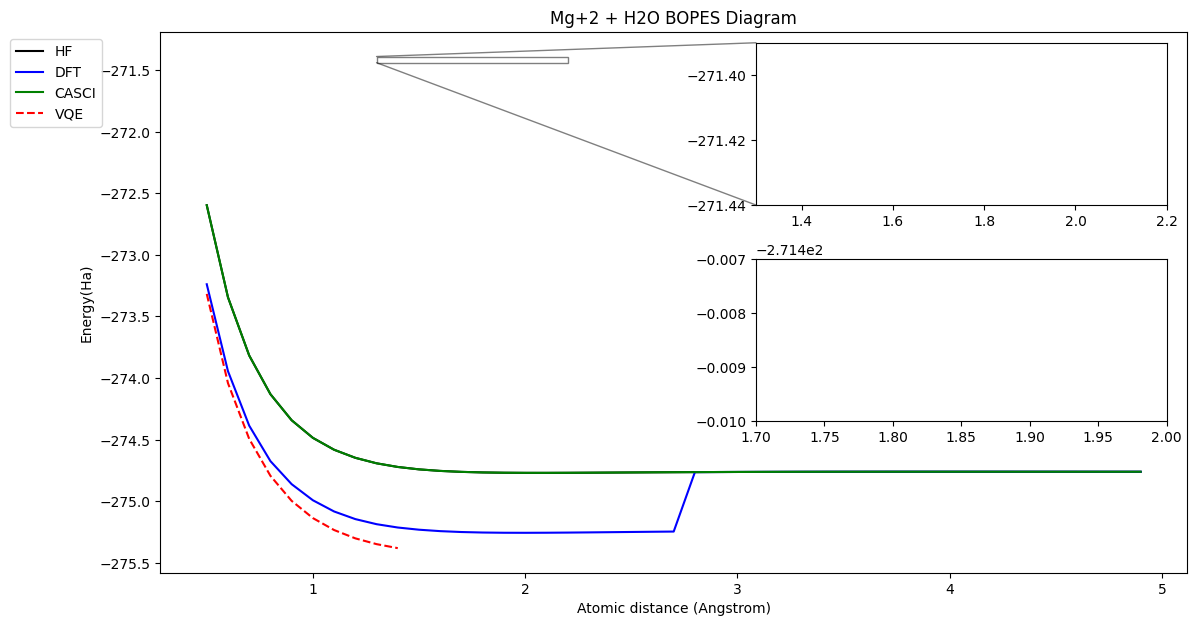

In [108]:
import matplotlib
import matplotlib.pyplot as plt

dists2=np.arange(0.5,1.5,0.1)

fig, ax=plt.subplots(1,1,figsize=(11,6))
fig.tight_layout()


#ax.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
#ax.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
ax.plot(dists,HF_engs, '-k',label="HF")
ax.plot(dists,DFT_engs, '-b',label="DFT")
ax.plot(dists,CI_engs, '-g',label="CASCI")
ax.plot(dists2,VQE_engs, '--r',label="VQE")

ax.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram')
#ax[0].set_xlim([0.7,4])
#ax[0].set_ylim([-148,-147])
ax.legend(bbox_to_anchor=(-.05,1))

axins = ax.inset_axes([0.58, 0.68, 0.4, 0.3])
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
axins.plot(dists,HF_engs, '-k',label="HF")
axins.plot(dists,DFT_engs, '-b',label="DFT")
axins.plot(dists,CI_engs, '-g',label="CASCI")
axins.plot(dists2,VQE_engs, '--r',label="VQE")

x1, x2, y1, y2 = 1.3,2.2, -271.44, -271.390
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
#axins.set_xticklabels([])
#axins.set_yticklabels([])

ax.indicate_inset_zoom(axins, edgecolor="black")

axins2 = ax.inset_axes([0.58, 0.28, 0.4, 0.3])
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
#axins.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
axins2.plot(dists,HF_engs, '-k',label="HF")
axins2.plot(dists,DFT_engs, '-b',label="DFT")
axins2.plot(dists,CI_engs, '-g',label="CASCI")
axins2.plot(dists2,VQE_engs, '--r',label="VQE")

xx1, xx2, yy1, yy2 = 1.7,2, -271.41, -271.407
axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)
#axins.set_xticklabels([])
#axins.set_yticklabels([])

#ax.indicate_inset_zoom(axins2, edgecolor="black")


#ax[1].plot(sim_results['RKS_distances'], -delta_classic*10**2, '--bo',label="RHF-RKS")
#ax[1].plot(sim_results['RKS_VQE_distances'], -delta_vqe*10**2, '--go',label="VQE_EMB-VQE")
#ax[1].plot(sim_results['RKS_distances'], -delta_vqecl*10**2, '--yo',label="VQE-RKS")
#ax[1].plot(sim_results['RKS_VQE_distances'], -delta_vqefci*10**2, '--co',label="VQE-FCI")
#ax[1].plot(sim_results['RKS_distances'], [0]*len(sim_results['RKS_distances']), '-r',label="Delta=0")
#ax[1].plot(sim_results['RKS_distances'], np.subtract(RHF_copy,sim_results['RKS_energies'][0])*10**3, '--bo',label="RHF-RKS")
#ax[1].plot(distances, exact_dipole,'r' ,label="Exact Energy")
#ax[1].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy Delta (%)',title="Energy Deltas between methods ")
#ax[1].legend()

plt.subplots_adjust(wspace=0.17)
plt.show()

In [106]:
VQE_engs=read('../VQE_MG+H2O_2')

In [107]:
VQE_engs

[array([-273.31682828]),
 array([-274.04145134]),
 array([-274.49382498]),
 array([-274.79362894]),
 array([-274.99704666]),
 array([-275.13676812]),
 array([-275.23378888]),
 array([-275.30140306]),
 array([-275.34822935]),
 array([-275.38077651])]

In [3]:
import pyscf